In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from factor_analyzer.rotator import Rotator
from concurrent.futures import ProcessPoolExecutor
import os

In [2]:
df_all = pd.read_csv('/Users/tanishq/PycharmProjects/NIScPR/FinTech/DerwentData_TS/ml/MainData.csv')
col = df_all['Application Date'].astype(str).str.strip().replace({'': pd.NA, 'nan': pd.NA})
dt = pd.to_datetime(col, format='mixed', dayfirst=True, errors='coerce')

df_all['Application Date'] = dt
df_all = df_all[(df_all['Application Date'] >= '2023-01-01') & (df_all['Application Date'] <= '2024-12-31')]


# df_ml = pd.read_csv('FinTech3OutputADA.csv')
df_ml = pd.read_csv('FinTechOutputADA.csv')
df_ml = df_ml[df_ml['High Quality'] == 1]

df_sem = pd.read_csv('QualityIndex(23-24).csv')
threshold = df_sem['Quality Index'].quantile(0.95)
df_sem = df_sem[df_sem['Quality Index'] > threshold]

In [3]:
df_sem.shape

(492, 20)

In [14]:
# df_ml = df_ml[df_ml['High Quality'] == 1]
df_ml

,Unnamed: 0,Publication Number,Application Date,Publication Date,IPC Subclass,Assignee Standardized,Claims Count,Assignee Count,Inventor Standardized,Publication Country Code,IPC Count,Inventor Count,Count of Cited Refs - Patent,Count of Cited Refs - Non-patent,Count of Citing Patents,DWPI Count of Family Members,DWPI Count of Family Countries/Regions,Legal Years Remaining,High Quality
0,0,IN202441099749A,2024-12-17,2024-12-20,H04L | G06Q,JAYAKANI S | RANI VENNILA FATHIMA S | BANU RAF...,10.0,5,JAYAKANI S | RANI VENNILA FATHIMA S | BANU RAF...,IN,1,5,0,0,0,1.0,1.0,19,1
4,4,IN202441096888A,2024-12-08,2024-12-13,G06Q | G06N | B32B,RAI KARUNAKARA B | HEMALATHA K J | PAREEK PIYU...,3.0,4,RAI KARUNAKARA B | HEMALATHA K J | PAREEK PIYU...,IN,1,3,0,0,0,1.0,1.0,19,1
8,8,IN202441096031A,2024-12-05,2024-12-13,G06Q | G06N,MUTHUKUMAR S | ROOPAA BHAWIYA S | DEEPAK G | A...,8.0,5,MUTHUKUMAR S | ROOPAA BHAWIYA S | DEEPAK G | A...,IN,1,5,0,0,0,1.0,1.0,19,1
12,12,CN119226536A,2024-12-02,2024-12-31,G06F | G06Q,BANK OF BEIJING CO LTD,10.0,1,DING ZHI YONG | PANG BO | WEI JU | SHEN YU XIN...,CN,1,12,10,0,2,1.0,1.0,19,1
13,13,CN119226501A,2024-12-02,2024-12-31,G06F | G06N,BANK OF BEIJING CO LTD,11.0,1,DING ZHI YONG | PANG BO | SHEN YU XIN | DANG M...,CN,1,11,4,0,3,1.0,1.0,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9792,29308,KR2846801B1,2023-01-26,2025-08-14,G06Q,KOREA BILLING SYSTEM CO LTD,9.0,1,SON SEUNGHWAN | YOOMIN JOON | PARK MISOON | RO...,KR,1,6,5,0,0,2.0,1.0,18,1
9793,29309,TH202301000421A,2023-01-24,2025-01-13,H04M | H04W,KAHN ARI,24.0,1,KAHN ARI,TH,1,1,0,0,0,15.0,137.0,15,1
9811,29327,CN115983982B,2023-01-09,2025-07-22,G06Q | G06F | G06N,SHENZHEN QIANHAI WEBANK CO LTD,8.0,1,HUANG MAO XIANG | ZHUANG QING | CHEN TING | WU...,CN,1,8,5,0,0,2.0,1.0,18,1
9817,29333,US12335193B2,2023-01-05,2025-06-17,H04L | H04W,LG ELECTRONICS INC | KOREA ADVANCED INSTITUTE ...,14.0,3,KEUM SEUNGWON | CHUNG JAEHOON | LEE SANGRIM | ...,US,1,8,10,0,0,5.0,135.0,15,1


In [5]:
# cols_to_keep = [
#     'Publication Number', 'Publication Date', 'Earliest Priority Year',
#     'Publication Country Code', 'Assignee Standardized',
#     'Inventor Standardized', 'IPC Subclass', 'Count of Cited Refs - Patent',
#     'Count of Cited Refs - Non-patent', 'Count of Citing Patents',
#     'DWPI Count of Family Members', 'Assignee Count', 'Inventor Count',
#     'Claims Count', 'Legal Years Remaining', 'IPC Count',
#     'DWPI Count of Family Countries/Regions', 'Application Date'
# ]
#
# df1 = pd.DataFrame()
# df1['Publication Number'] = df_ml['Publication Number']
# # Perform the merge
# result = df1.merge(
#     df_all[cols_to_keep],
#     on='Publication Number',   # join key
#     how='left'                 # or 'inner' if you only want exact matches
# )
# result.to_csv('TopML_3Indicators.csv', index=False)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from collections import Counter

ipc_labels = {
    "H04W": "Wireless communication networks",
    "G06Q": "Data processing for admin/finance/commerce",
    "G06F": "Electric digital data processing (computers)",
    "H04L": "Transmission of digital information",
    "H04B": "Transmission (general)",
    "G06N": "Computer systems based on specific models (AI/NN etc.)",
    "G06V": "Image or video recognition / understanding",
    "G06K": "Recognition/presentation of data; record carriers",
    "G10L": "Speech analysis, synthesis, recognition",
    "H04N": "Pictorial communication (television, video)",
    "G06T": "Image data processing or generation (general)",
    "G01S": "Radio direction-finding, navigation, radar",
    "G07F": "Coin-freed/vending apparatus",
    "H04M": "Telephonic communication",
    "H04J": "Multiplex communication",
    "G08G": "Traffic control systems",
    "G16H": "Health informatics (ICT for healthcare)",
    "B60W": "Conjoint control of vehicle sub-units",
    "H03M": "Coding, decoding, or code conversion",
    "G07G": "Cash register / point-of-sale systems",
    "G07C": "Time/attendance; machine work logging; access/ID; fee/toll registers",
    "G01C": "Measuring distances, bearings; surveying; navigation; gyros; photogrammetry",
    "G05B": "Control or regulating systems in general; programmable/sequence controllers",
    "G07D": "Handling coins or paper currency; authenticity testing; cash/banknote processing",
    "G11B": "INFORMATION STORAGE BASED ON RELATIVE MOVEMENT BETWEEN RECORD CARRIER AND TRANSDUCER",
}

def plot_top_entities_combined(
    dfs: dict,
    column: str,
    k_per_record: int = 1,
    top_n: int = 20,
    wrap_width: int = 40,
    xlabel: str = "Number of Patents",
    ylabel: str = "Entity",
    title: str = "Top Entities Comparison",
    figsize=(14, 9),
    exclude=None,
    label_map=None,
    label_mode: str = "code+label",
    label_offset_frac: float = 0.04,   # 4% of bar width
    label_offset_min: float = 0.0      # at least this many units
):
    if not isinstance(dfs, dict) or len(dfs) == 0:
        raise ValueError("dfs must be a non-empty dict of name->DataFrame.")
    for name, df in dfs.items():
        if column not in df.columns:
            raise KeyError(f"Column '{column}' not in DataFrame '{name}'.")

    def top_k(entry: str) -> str:
        if not isinstance(entry, str):
            return ""
        parts = [x.strip() for x in entry.split(",") if x.strip()]
        return " | ".join(parts[:k_per_record]) if k_per_record > 0 else ""

    def wrap_labels(label: str) -> str:
        return "\n".join(textwrap.wrap(str(label), wrap_width)) if label else ""

    ex = set(exclude or set())

    # row-normalized counts
    count_dfs = []
    for name, df in dfs.items():
        df_tmp = df.copy()
        df_tmp[column + "_top"] = df_tmp[column].apply(top_k)

        counts = Counter()
        for entry in df_tmp[column + "_top"]:
            if isinstance(entry, str) and entry.strip():
                ents = {
                    ent.strip() for ent in entry.split("|")
                    if ent.strip() and ent.strip() not in ex
                }
                if ents:
                    w = 1.0 / len(ents)
                    for key in ents:
                        counts[key] += w

        count_df = pd.DataFrame(counts.items(), columns=[column, name])
        count_dfs.append(count_df)

    # merge and rank
    merged_counts = count_dfs[0]
    for df_ in count_dfs[1:]:
        merged_counts = pd.merge(merged_counts, df_, on=column, how="outer")
    merged_counts = merged_counts.fillna(0)

    value_cols = [c for c in merged_counts.columns if c != column]
    merged_counts["Total"] = merged_counts[value_cols].sum(axis=1)
    merged_counts = merged_counts.sort_values("Total", ascending=False).head(top_n).copy()

    # labels
    if label_map:
        def build_label(code: str) -> str:
            desc = label_map.get(code)
            return code if not desc else (desc if label_mode == "replace" else f"{code} – {desc}")
        merged_counts["label"] = merged_counts[column].map(build_label)
    else:
        merged_counts["label"] = merged_counts[column]
    merged_counts["wrapped"] = merged_counts["label"].apply(wrap_labels)

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    y = range(len(merged_counts))
    n_series = max(1, len(dfs))
    height = 0.8 / n_series

    palette = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0","C1","C2","C3","C4","C5"])
    colors = (palette * ((n_series // len(palette)) + 1))[:n_series]

    # global max to set xlim and compute a safe outer margin
    global_max = 0.0
    for name in dfs.keys():
        if name in merged_counts:
            global_max = max(global_max, float(merged_counts[name].max() or 0.0))
    xmax = global_max * 1.12 if global_max > 0 else 1.0
    ax.set_xlim(0, xmax)

    for i, (name, color) in enumerate(zip(list(dfs.keys()), colors)):
        vals = merged_counts[name].values if name in merged_counts else [0]*len(merged_counts)
        bars = ax.barh(
            [pos + i * height for pos in y],
            vals,
            height=height,
            label=name,
            color=color,
        )
        for bar in bars:
            w = bar.get_width()
            if w > 0:
                # adaptive label offset
                offset = max(label_offset_frac * w, label_offset_min)
                x_text = min(w + offset, xmax * 0.995)  # keep inside axes
                ax.text(
                    x_text,
                    bar.get_y() + bar.get_height() / 2,
                    f"{w:.2f}",
                    va="center",
                    ha="right" if x_text >= xmax * 0.99 else "left",
                    fontsize=8,
                )

    mid_offset = (n_series - 1) * height / 2
    ax.set_yticks([pos + mid_offset for pos in y], merged_counts["wrapped"], fontsize=8)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.invert_yaxis()
    plt.xscale("symlog", linthresh=10)
    fig.tight_layout()
    plt.show()

    return merged_counts

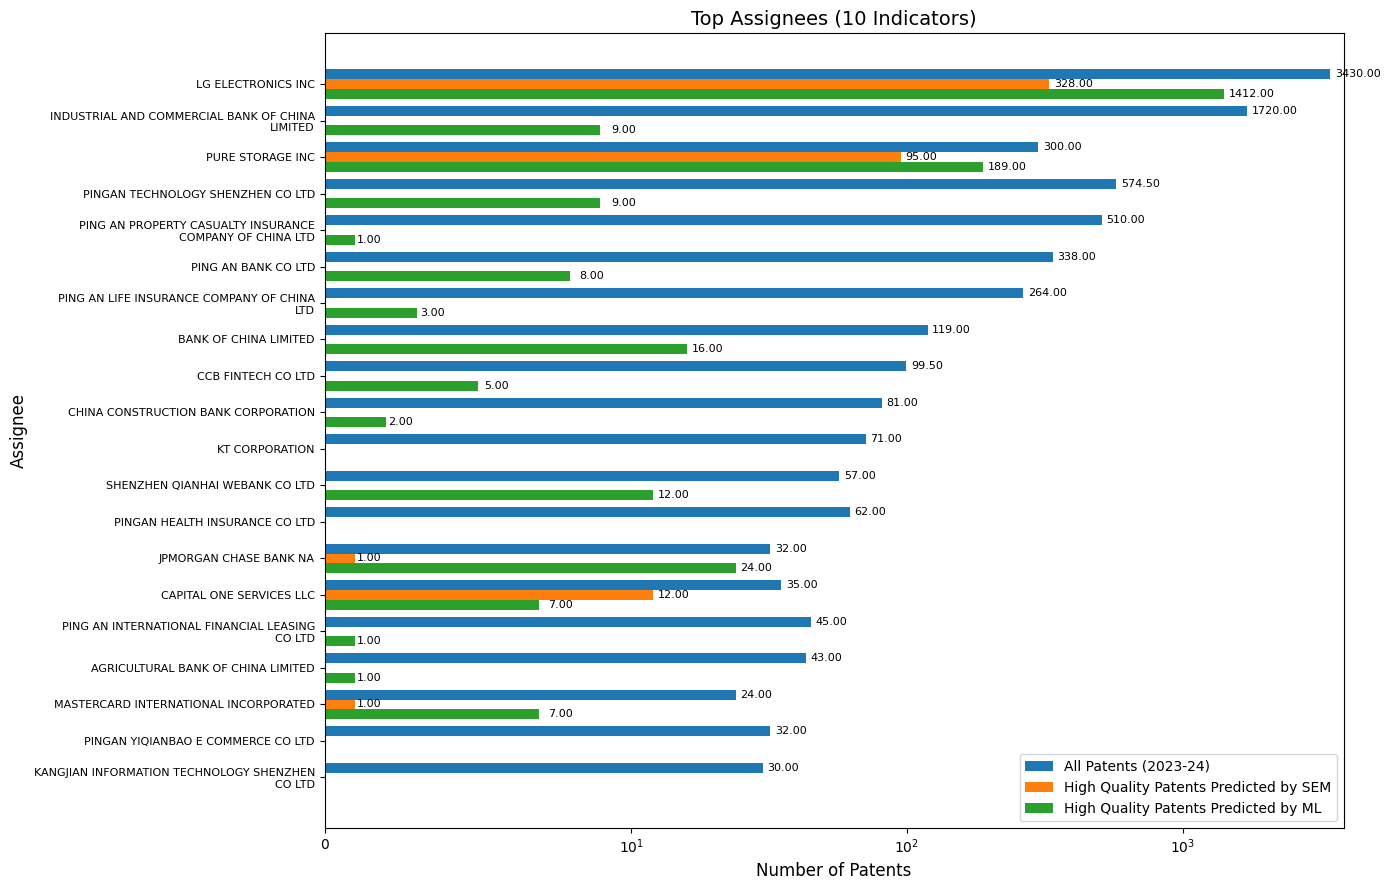

,Assignee Standardized,All Patents (2023-24),High Quality Patents Predicted by SEM,High Quality Patents Predicted by ML,Total,label,wrapped
844,LG ELECTRONICS INC,3430.0,328.0,1412.0,5170.0,LG ELECTRONICS INC,LG ELECTRONICS INC
605,INDUSTRIAL AND COMMERCIAL BANK OF CHINA LIMITED,1720.0,0.0,9.0,1729.0,INDUSTRIAL AND COMMERCIAL BANK OF CHINA LIMITED,INDUSTRIAL AND COMMERCIAL BANK OF CHINA\nLIMITED
1155,PURE STORAGE INC,300.0,95.0,189.0,584.0,PURE STORAGE INC,PURE STORAGE INC
1110,PINGAN TECHNOLOGY SHENZHEN CO LTD,574.5,0.0,9.0,583.5,PINGAN TECHNOLOGY SHENZHEN CO LTD,PINGAN TECHNOLOGY SHENZHEN CO LTD
1103,PING AN PROPERTY CASUALTY INSURANCE COMPANY OF...,510.0,0.0,1.0,511.0,PING AN PROPERTY CASUALTY INSURANCE COMPANY OF...,PING AN PROPERTY CASUALTY INSURANCE\nCOMPANY O...
1099,PING AN BANK CO LTD,338.0,0.0,8.0,346.0,PING AN BANK CO LTD,PING AN BANK CO LTD
1102,PING AN LIFE INSURANCE COMPANY OF CHINA LTD,264.0,0.0,3.0,267.0,PING AN LIFE INSURANCE COMPANY OF CHINA LTD,PING AN LIFE INSURANCE COMPANY OF CHINA\nLTD
116,BANK OF CHINA LIMITED,119.0,0.0,16.0,135.0,BANK OF CHINA LIMITED,BANK OF CHINA LIMITED
235,CCB FINTECH CO LTD,99.5,0.0,5.0,104.5,CCB FINTECH CO LTD,CCB FINTECH CO LTD
271,CHINA CONSTRUCTION BANK CORPORATION,81.0,0.0,2.0,83.0,CHINA CONSTRUCTION BANK CORPORATION,CHINA CONSTRUCTION BANK CORPORATION


In [7]:
plot_top_entities_combined(
    dfs={"All Patents (2023-24)": df_all, "High Quality Patents Predicted by SEM": df_sem, "High Quality Patents Predicted by ML": df_ml},
    column="Assignee Standardized",
    ylabel="Assignee",
    title="Top Assignees (10 Indicators)",
    k_per_record=1,
    top_n=20
)

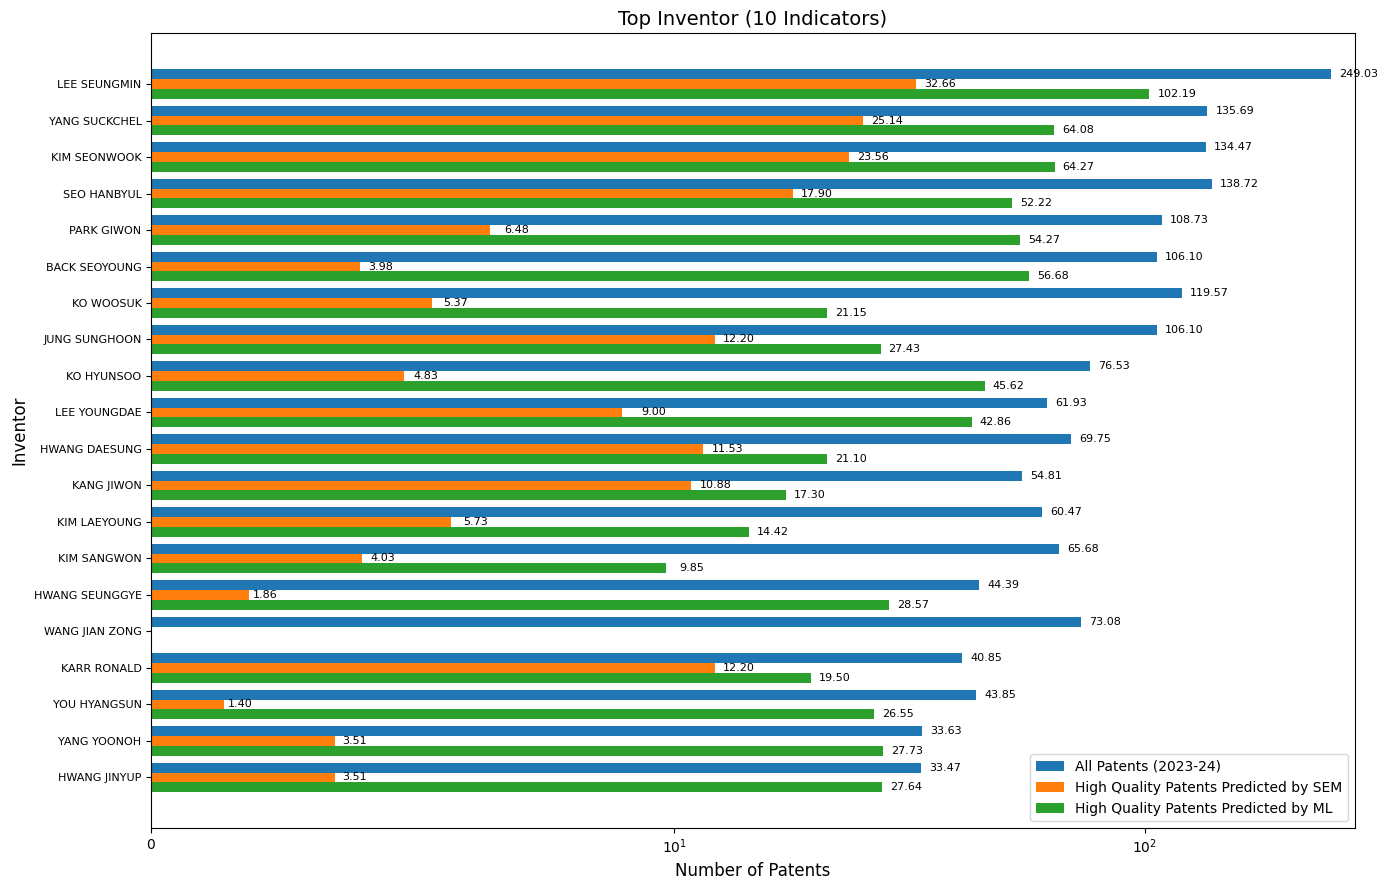

,Inventor Standardized,All Patents (2023-24),High Quality Patents Predicted by SEM,High Quality Patents Predicted by ML,Total,label,wrapped
3483,LEE SEUNGMIN,249.028571,32.659524,102.185714,383.873810,LEE SEUNGMIN,LEE SEUNGMIN
8224,YANG SUCKCHEL,135.688095,25.140476,64.076190,224.904762,YANG SUCKCHEL,YANG SUCKCHEL
3164,KIM SEONWOOK,134.466667,23.557143,64.271429,222.295238,KIM SEONWOOK,KIM SEONWOOK
6001,SEO HANBYUL,138.716667,17.900000,52.216667,208.833333,SEO HANBYUL,SEO HANBYUL
5339,PARK GIWON,108.733333,6.483333,54.266667,169.483333,PARK GIWON,PARK GIWON
153,BACK SEOYOUNG,106.100000,3.983333,56.683333,166.766667,BACK SEOYOUNG,BACK SEOYOUNG
3242,KO WOOSUK,119.567857,5.366667,21.151190,146.085714,KO WOOSUK,KO WOOSUK
2923,JUNG SUNGHOON,106.100000,12.200000,27.433333,145.733333,JUNG SUNGHOON,JUNG SUNGHOON
3240,KO HYUNSOO,76.533333,4.828571,45.623810,126.985714,KO HYUNSOO,KO HYUNSOO
3502,LEE YOUNGDAE,61.930952,9.002381,42.861905,113.795238,LEE YOUNGDAE,LEE YOUNGDAE


In [8]:
plot_top_entities_combined(
    dfs={"All Patents (2023-24)": df_all, "High Quality Patents Predicted by SEM": df_sem, "High Quality Patents Predicted by ML": df_ml},
    column="Inventor Standardized",
    ylabel="Inventor",
    title="Top Inventor (10 Indicators)",
    k_per_record=1,
    top_n=20
)

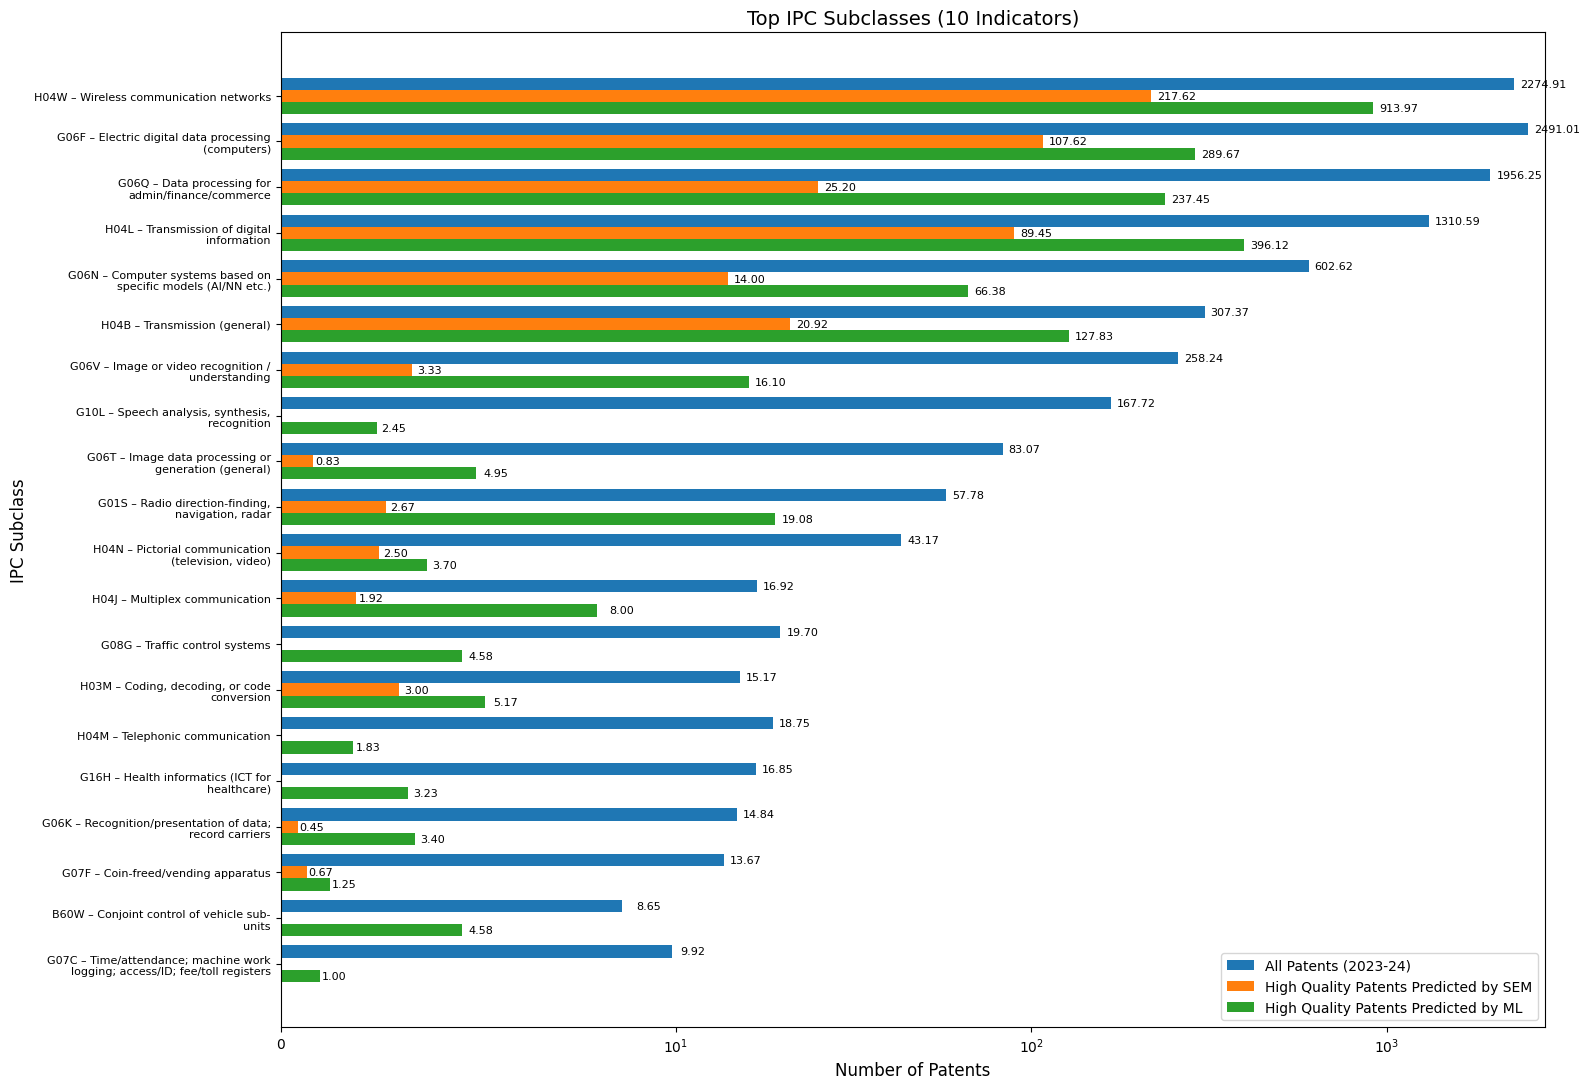

,IPC Subclass,All Patents (2023-24),High Quality Patents Predicted by SEM,High Quality Patents Predicted by ML,Total,label,wrapped
122,H04W,2274.909524,217.616667,913.966667,3406.492857,H04W – Wireless communication networks,H04W – Wireless communication networks
80,G06F,2491.009524,107.616667,289.666667,2888.292857,G06F – Electric digital data processing (compu...,G06F – Electric digital data processing\n(comp...
84,G06Q,1956.252381,25.200000,237.450000,2218.902381,G06Q – Data processing for admin/finance/commerce,G06Q – Data processing for\nadmin/finance/comm...
117,H04L,1310.592857,89.450000,396.116667,1796.159524,H04L – Transmission of digital information,H04L – Transmission of digital\ninformation
83,G06N,602.616667,14.000000,66.383333,683.000000,G06N – Computer systems based on specific mode...,G06N – Computer systems based on\nspecific mod...
114,H04B,307.366667,20.916667,127.833333,456.116667,H04B – Transmission (general),H04B – Transmission (general)
86,G06V,258.242857,3.333333,16.100000,277.676190,G06V – Image or video recognition / understanding,G06V – Image or video recognition /\nunderstan...
99,G10L,167.716667,0.000000,2.450000,170.166667,"G10L – Speech analysis, synthesis, recognition","G10L – Speech analysis, synthesis,\nrecognition"
85,G06T,83.066667,0.833333,4.950000,88.850000,G06T – Image data processing or generation (ge...,G06T – Image data processing or\ngeneration (g...
72,G01S,57.783333,2.666667,19.083333,79.533333,"G01S – Radio direction-finding, navigation, radar","G01S – Radio direction-finding,\nnavigation, r..."


In [9]:
plot_top_entities_combined(
    dfs={"All Patents (2023-24)": df_all, "High Quality Patents Predicted by SEM": df_sem, "High Quality Patents Predicted by ML": df_ml},
    column="IPC Subclass",
    k_per_record=1,
    title="Top IPC Subclasses (10 Indicators)",
    ylabel="IPC Subclass",
    label_map=ipc_labels,
    label_mode="code+label",
    figsize=(16, 11)

)

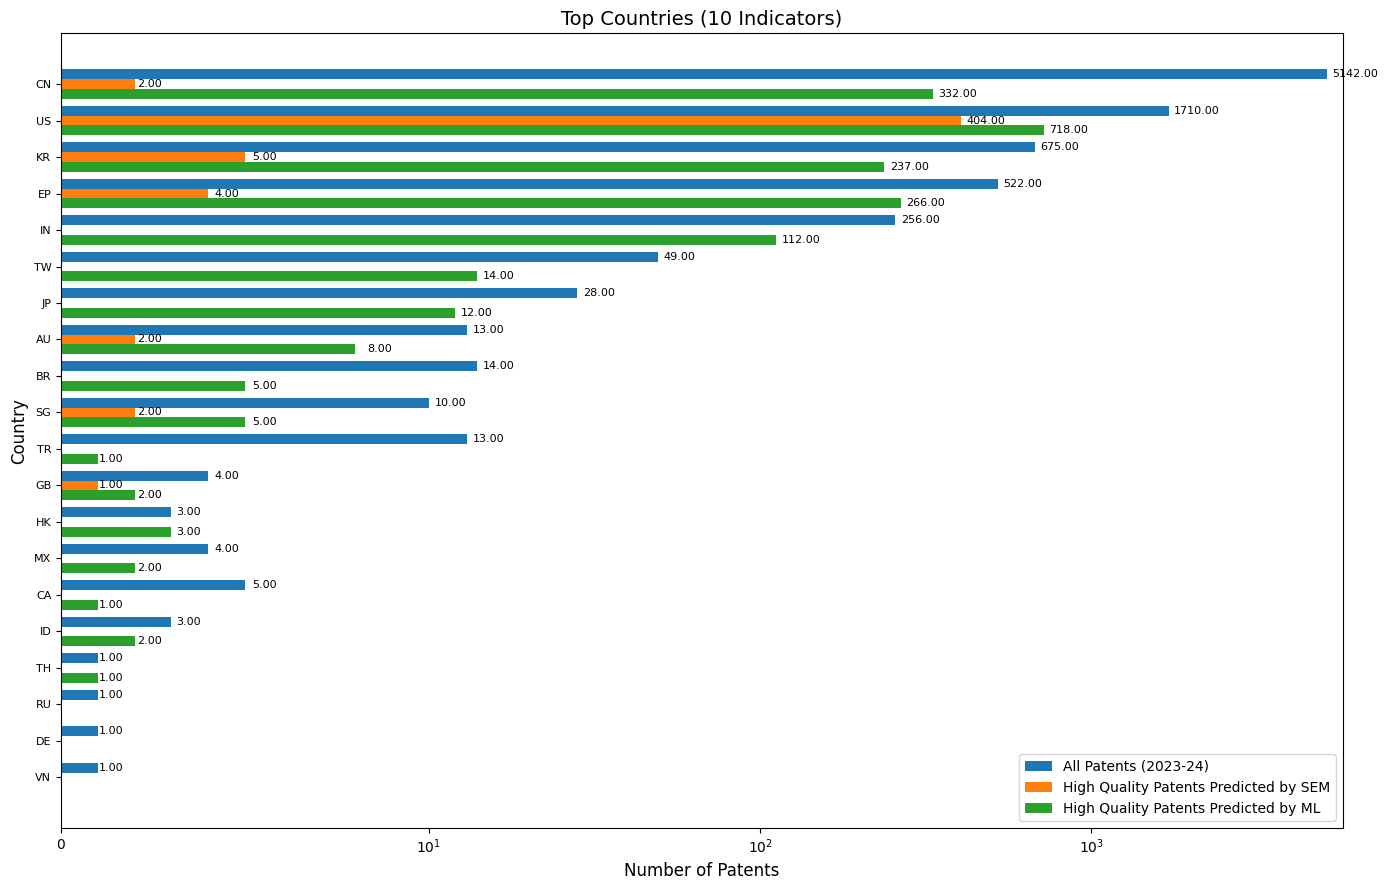

,Publication Country Code,All Patents (2023-24),High Quality Patents Predicted by SEM,High Quality Patents Predicted by ML,Total,label,wrapped
3,CN,5142.0,2.0,332.0,5476.0,CN,CN
18,US,1710.0,404.0,718.0,2832.0,US,US
11,KR,675.0,5.0,237.0,917.0,KR,KR
5,EP,522.0,4.0,266.0,792.0,EP,EP
9,IN,256.0,0.0,112.0,368.0,IN,IN
17,TW,49.0,0.0,14.0,63.0,TW,TW
10,JP,28.0,0.0,12.0,40.0,JP,JP
0,AU,13.0,2.0,8.0,23.0,AU,AU
1,BR,14.0,0.0,5.0,19.0,BR,BR
14,SG,10.0,2.0,5.0,17.0,SG,SG


In [10]:
plot_top_entities_combined(
    dfs={"All Patents (2023-24)": df_all, "High Quality Patents Predicted by SEM": df_sem, "High Quality Patents Predicted by ML": df_ml},
    column="Publication Country Code",
    k_per_record=1,
    title="Top Countries (10 Indicators)",
    ylabel="Country",
    exclude={"WO"}                 # <- ignore WO
)

In [11]:
common_df = df_sem[df_sem["Publication Number"].isin(df_ml["Publication Number"])]


In [12]:
common_df.shape

(187, 20)

In [13]:
common_df.to_csv('Common_3.csv', index=False)